In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

from sklearn.cluster import KMeans
import joblib
import contextily as ctx

## data

In [3]:
df_list = []
for year in range(2000, 2024):
  if year % 2 == 0 and year != 2024:
    df_temp = pd.read_csv(f'Combined_Sampled_Points_{year}-{year+1}.csv')
    df_list.append(df_temp)
  else:
    continue
  if year == 2024:
    df_temp = pd.read_csv(f'Combined_Sampled_Points_{year}.csv')
    df_list.append(df_temp)

df = pd.concat(df_list, ignore_index=True)

In [4]:
df['Month'] = pd.to_datetime(df['Month'], format='%B').dt.month
df['Quarter'] = ((df['Month'] - 1) // 3 + 1).astype(int)

In [5]:
df['Wind_Speed'] = np.sqrt(np.abs(df['u10_wind'] + df['v10_wind']))

# Create dummy variables for 'Fuel_Type'
fuel_dummies = pd.get_dummies(df['Fuel_Type'], prefix='Fuel', drop_first=True)
df = pd.concat([df, fuel_dummies], axis=1)
df.drop('Fuel_Type', axis=1, inplace=True)

# Convert boolean columns to integers (assuming boolean columns exist)
for col in df.select_dtypes(include=['bool']):
    df[col] = df[col].astype(int)
df

,X,Y,Latitude,Longitude,Month,Year,Fire,u10_wind,v10_wind,dew_temp_2m,...,Fuel_105,Fuel_107,Fuel_108,Fuel_109,Fuel_116,Fuel_118,Fuel_119,Fuel_120,Fuel_121,Fuel_122
0,4.140919e+06,2.270019e+06,51.897400,-123.359968,1,2000,0,-0.097003,-0.097003,-0.097003,...,0,0,1,0,0,0,0,0,0,0
1,4.396760e+06,3.056396e+06,59.323175,-126.042198,1,2000,0,0.479657,0.479657,0.479657,...,0,0,0,0,0,0,0,0,0,0
2,4.206559e+06,2.080199e+06,50.644213,-121.255199,1,2000,0,-0.376300,-0.376300,-0.376300,...,0,0,1,0,0,0,0,0,0,0
3,4.382204e+06,2.472235e+06,54.548869,-121.531047,1,2000,0,-0.480304,-0.480304,-0.480304,...,0,0,0,0,0,0,0,0,0,0
4,4.162832e+06,2.212252e+06,51.528335,-122.680452,1,2000,0,0.999677,0.999677,0.999677,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2263354,4.051877e+06,2.526236e+06,53.520431,-126.423986,12,2023,0,-0.168617,0.656361,NaN,...,0,0,0,0,0,0,0,0,0,0
2263355,4.237767e+06,2.191930e+06,51.675814,-121.574410,12,2023,0,-1.715004,2.388294,NaN,...,0,0,0,0,0,0,0,0,0,0
2263356,4.512095e+06,3.045552e+06,59.767470,-124.126729,12,2023,0,1.059898,0.815540,NaN,...,0,0,1,0,0,0,0,0,0,0
2263357,4.000697e+06,3.256192e+06,58.783496,-133.920741,12,2023,0,-0.212517,0.251448,NaN,...,0,0,0,0,0,0,1,0,0,0


In [6]:
df[['dew_temp_2m', 'temp_2m', 'tot_precip', 'lai_high','dew_temp_2']].describe()

,dew_temp_2m,temp_2m,tot_precip,lai_high,dew_temp_2
count,4789.000000,2.263359e+06,2.263359e+06,2.263359e+06,2.258570e+06
mean,0.308137,2.844913e+02,2.375685e-03,2.735329e+00,2.771805e+02
std,0.654347,1.483979e+01,3.327301e-02,6.692402e-01,5.028214e+00
min,-2.095512,-2.095512e+00,-2.095512e+00,-2.095512e+00,2.417405e+02
25%,-0.122095,2.837558e+02,7.934570e-04,2.238647e+00,2.764311e+02
50%,0.332983,2.872016e+02,1.300812e-03,2.675781e+00,2.783868e+02
75%,0.757010,2.891964e+02,2.120972e-03,3.199585e+00,2.798967e+02
max,3.725000,2.964262e+02,3.725000e+00,5.458862e+00,2.893283e+02


### group

In [8]:
coords = df[['Latitude', 'Longitude']]
clusters=70
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(coords)
df['region'] = kmeans.labels_ 
df

C:\Users\YU\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\YU\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\YU\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\YU\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\YU\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable

,X,Y,Latitude,Longitude,Month,Year,Fire,u10_wind,v10_wind,dew_temp_2m,...,Fuel_107,Fuel_108,Fuel_109,Fuel_116,Fuel_118,Fuel_119,Fuel_120,Fuel_121,Fuel_122,region
0,4.140919e+06,2.270019e+06,51.897400,-123.359968,1,2000,0,-0.097003,-0.097003,-0.097003,...,0,1,0,0,0,0,0,0,0,22
1,4.396760e+06,3.056396e+06,59.323175,-126.042198,1,2000,0,0.479657,0.479657,0.479657,...,0,0,0,0,0,0,0,0,0,67
2,4.206559e+06,2.080199e+06,50.644213,-121.255199,1,2000,0,-0.376300,-0.376300,-0.376300,...,0,1,0,0,0,0,0,0,0,2
3,4.382204e+06,2.472235e+06,54.548869,-121.531047,1,2000,0,-0.480304,-0.480304,-0.480304,...,0,0,0,0,0,0,0,0,0,35
4,4.162832e+06,2.212252e+06,51.528335,-122.680452,1,2000,0,0.999677,0.999677,0.999677,...,0,0,0,1,0,0,0,0,0,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2263354,4.051877e+06,2.526236e+06,53.520431,-126.423986,12,2023,0,-0.168617,0.656361,NaN,...,0,0,0,0,0,0,0,0,0,10
2263355,4.237767e+06,2.191930e+06,51.675814,-121.574410,12,2023,0,-1.715004,2.388294,NaN,...,0,0,0,0,0,0,0,0,0,40
2263356,4.512095e+06,3.045552e+06,59.767470,-124.126729,12,2023,0,1.059898,0.815540,NaN,...,0,1,0,0,0,0,0,0,0,15
2263357,4.000697e+06,3.256192e+06,58.783496,-133.920741,12,2023,0,-0.212517,0.251448,NaN,...,0,0,0,0,0,1,0,0,0,57


In [9]:
# 4 quarter
df_by_q = {}

for i in range(1, 5):
    df_by_q[f'df{i}'] = df[df['Quarter'] == i]

df1 = df_by_q['df1']
df2 = df_by_q['df2']
df3 = df_by_q['df3']
df4 = df_by_q['df4']

### maps

C:\Users\YU\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


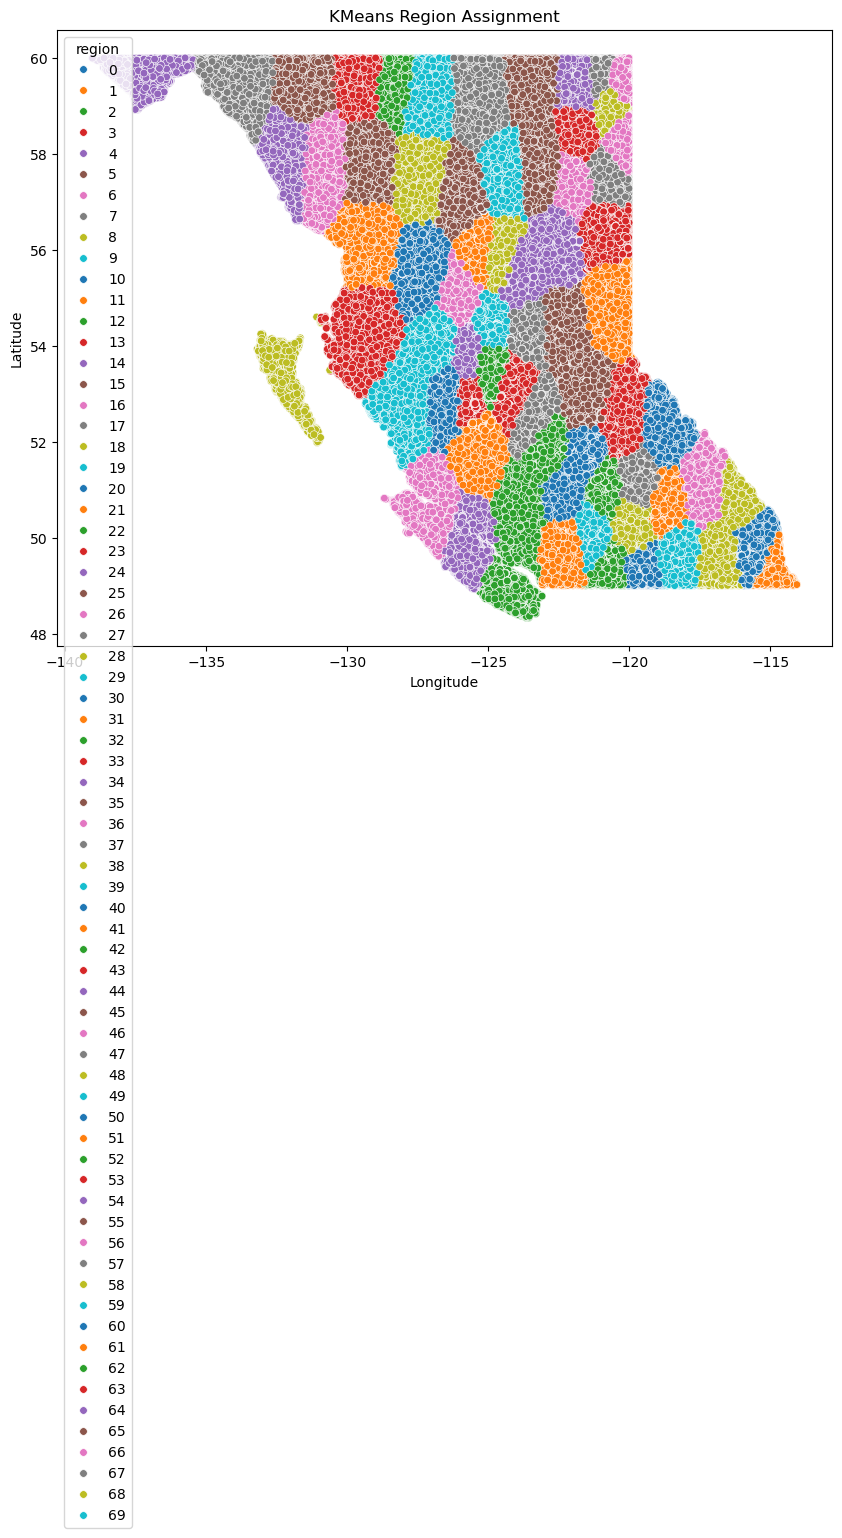

In [11]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df,
    x='Longitude',
    y='Latitude',
    hue='region',
    palette='tab10',
    s=30
)
plt.title("KMeans Region Assignment")
#plt.legend(title='Region')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## model

### load models

In [14]:
rf = joblib.load('random_forest.pkl')

### average

In [16]:
df.columns
# X columns:'dew_temp_2', 'temp_2m', 'tot_precip', 'lai_high', 'Fuel_102','Fuel_103', 'Fuel_105', 'Fuel_107', 'Fuel_108', 'Fuel_109', 'Fuel_116',
            #'Fuel_118', 'Fuel_119', 'Fuel_120', 'Fuel_121', 'Fuel_122','Wind_Speed'

Index(['X', 'Y', 'Latitude', 'Longitude', 'Month', 'Year', 'Fire', 'u10_wind',
       'v10_wind', 'dew_temp_2m', 'temp_2m', 'tot_precip', 'lai_high',
       'dew_temp_2', 'Quarter', 'Wind_Speed', 'Fuel_102', 'Fuel_103',
       'Fuel_105', 'Fuel_107', 'Fuel_108', 'Fuel_109', 'Fuel_116', 'Fuel_118',
       'Fuel_119', 'Fuel_120', 'Fuel_121', 'Fuel_122', 'region'],
      dtype='object')

In [17]:
df1[['dew_temp_2m', 'temp_2m', 'tot_precip', 'lai_high', 'dew_temp_2']].describe()

,dew_temp_2m,temp_2m,tot_precip,lai_high,dew_temp_2
count,491.000000,78676.000000,78676.000000,78676.000000,78185.000000
mean,-0.126964,263.864124,0.002414,1.958801,262.430269
std,0.813612,21.745621,0.065104,0.714386,6.128117
min,-2.002656,-2.002656,-2.002656,-2.002656,243.839401
25%,-0.696352,261.401123,0.001129,1.499023,258.213684
50%,-0.223509,265.323624,0.002007,1.741821,262.432861
75%,0.345610,269.422302,0.003879,2.322266,266.695251
max,2.805788,281.863281,2.805788,4.806396,279.814392


In [18]:
# choose a point from each region
N=10
Scen=3
for i in range(4):
    data=globals()[f'df{i+1}']
    tempdf=data.groupby('region').sample(n=150, random_state= ).reset_index()
    tempdf['dew_temp_2']=tempdf.groupby('region')['dew_temp_2'].transform('mean')
    tempdf['temp_2m']=tempdf.groupby('region')['temp_2m'].transform('mean')
    tempdf['tot_precip']=tempdf.groupby('region')['tot_precip'].transform('mean')
    tempdf['lai_high']=tempdf.groupby('region')['lai_high'].transform('mean')
    tempdf['Wind_Speed']=tempdf.groupby('region')['Wind_Speed'].transform('mean')
    result_y=rf.predict(tempdf[['dew_temp_2', 'temp_2m', 'tot_precip', 'lai_high', 'Fuel_102','Fuel_103', 'Fuel_105', 'Fuel_107', \
                                      'Fuel_108', 'Fuel_109', 'Fuel_116','Fuel_118', 'Fuel_119', 'Fuel_120', 'Fuel_121', 'Fuel_122','Wind_Speed']])
    result_y=pd.DataFrame(result_y, columns=[f"Predi_Fire{i+1}"])
    globals()[f'result{i+1}']=pd.concat([tempdf[['Latitude', 'Longitude']], result_y], axis=1)

In [19]:
result=pd.merge(result1, result2, how='outer', on=['Latitude','Longitude'])
result=pd.merge(result, result3, how='outer', on=['Latitude','Longitude'])
result=pd.merge(result, result4, how='outer', on=['Latitude','Longitude'])
result=result.fillna(0)
result

,Latitude,Longitude,Predi_Fire1,Predi_Fire2,Predi_Fire3,Predi_Fire4
0,48.358676,-123.583221,0.0,0.0,0.0,0.0
1,48.389643,-123.539093,0.0,0.0,0.0,0.0
2,48.405200,-123.932000,0.0,0.0,0.0,0.0
3,48.406799,-123.806511,0.0,0.0,0.0,0.0
4,48.407631,-123.835320,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
41992,59.999199,-121.259903,0.0,1.0,0.0,0.0
41993,59.999205,-130.697211,0.0,0.0,0.0,0.0
41994,59.999385,-122.620005,0.0,0.0,0.0,0.0
41995,59.999668,-121.543228,0.0,0.0,0.0,0.0


In [20]:
#result.to_excel('Average.xlsx')

### temp+std

In [37]:
# choose a point from each region
N=10
Scen=3
for i in range(4):
    data=globals()[f'df{i+1}']
    tempdf=data.groupby('region').sample(n=150, random_state= ).reset_index()
    tempdf['dew_temp_2']=tempdf.groupby('region')['dew_temp_2'].transform('mean')#-tempdf.groupby('region')['dew_temp_2'].transform('std')
    tempdf['temp_2m']=tempdf.groupby('region')['temp_2m'].transform('mean')+tempdf.groupby('region')['temp_2m'].transform('std')
    tempdf['tot_precip']=tempdf.groupby('region')['tot_precip'].transform('mean')
    tempdf['lai_high']=tempdf.groupby('region')['lai_high'].transform('mean')
    tempdf['Wind_Speed']=tempdf.groupby('region')['Wind_Speed'].transform('mean')
    result_y=rf.predict(tempdf[['dew_temp_2', 'temp_2m', 'tot_precip', 'lai_high', 'Fuel_102','Fuel_103', 'Fuel_105', 'Fuel_107', \
                                      'Fuel_108', 'Fuel_109', 'Fuel_116','Fuel_118', 'Fuel_119', 'Fuel_120', 'Fuel_121', 'Fuel_122','Wind_Speed']])
    result_y=pd.DataFrame(result_y, columns=[f"Predi_Fire{i+1}"])
    globals()[f'result{i+1}']=pd.concat([tempdf[['Latitude', 'Longitude']], result_y], axis=1)

In [40]:
result_w=pd.merge(result1, result2, how='outer', on=['Latitude','Longitude'])
result_w=pd.merge(result, result3, how='outer', on=['Latitude','Longitude'])
result_w=pd.merge(result, result4, how='outer', on=['Latitude','Longitude'])
result_w=result.fillna(0)
result_w

,Latitude,Longitude,Predi_Fire1,Predi_Fire2,Predi_Fire3,Predi_Fire4
0,48.358676,-123.583221,0.0,0.0,0.0,0.0
1,48.389643,-123.539093,0.0,0.0,0.0,0.0
2,48.405200,-123.932000,0.0,0.0,0.0,0.0
3,48.406799,-123.806511,0.0,0.0,0.0,0.0
4,48.407631,-123.835320,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
41992,59.999199,-121.259903,0.0,0.0,0.0,0.0
41993,59.999205,-130.697211,0.0,0.0,0.0,0.0
41994,59.999385,-122.620005,0.0,0.0,0.0,0.0
41995,59.999668,-121.543228,0.0,0.0,0.0,0.0


In [28]:
#result_w.to_excel('Warmer.xlsx')